## TC 5033
#### Activity 4: Implementing a Translator

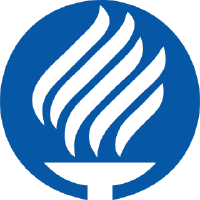


## TEAM 33
| ID          | Name                          |
|-------------|-------------------------------|
| A01794956   | Luis Oporto                   |
| A00915255   | Ernesto Zapata                |
| A01065270   | José Manuel Romo Peredo       |
| A01795483   | Nicolás Araque                |
| A01794892   | Eduardo Rodriguez Ramirez     |

- Objective

To understand the Transformer Architecture by Implementing a translator.

- Instructions

    This activity requires submission in teams. While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Follow the provided code. The code already implements a transformer from scratch as explained in one of [week's 9 videos](https://youtu.be/XefFj4rLHgU)

    Since the provided code already implements a simple translator, your job for this assignment is to understand it fully, and document it using pictures, figures, and markdown cells.  You should test your translator with at least 10 sentences. The dataset used for this task was obtained from [Tatoeba, a large dataset of sentences and translations](https://tatoeba.org/en/downloads).
  
- Evaluation Criteria

    - Code Readability and Comments
    - Traning a translator
    - Translating at least 10 sentences.

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.



#### Script to convert csv to text file 

In [1]:
#This script requires to convert the TSV file to CSV
# easiest way is to open it in Calc or excel and save as csv
PATH = './data/input_spa_eng.csv'
import pandas as pd
df = pd.read_csv(PATH, sep='\t')

In [2]:
df.head()

,2481,¡Intentemos algo!,1276,Let's try something.
0,2482,Tengo que irme a dormir.,1277.0,I have to go to sleep.
1,2483,¿Qué estás haciendo?,16492.0,What are you doing?
2,2483,¿Qué estás haciendo?,241947.0,What are you doing now?
3,2483,¿Qué estás haciendo?,516639.0,What are you up to?
4,2484,¿Qué es eso?,42849.0,What is it?


In [3]:
eng_spa_cols = df.iloc[:, [1, 3]]
eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()  
eng_spa_cols = eng_spa_cols.sort_values(by='length')  
eng_spa_cols = eng_spa_cols.drop(columns=['length'])  

output_file_path = './data/eng-spa4.txt'
eng_spa_cols.to_csv(output_file_path, sep='\t', index=False, header=False)

C:\Users\AMD RYZEN 7\AppData\Local\Temp\ipykernel_22364\583859432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_spa_cols['length'] = eng_spa_cols.iloc[:, 0].str.len()


### Transformer - Attention is all you need

This portion of code contains the key components of our Transformer model for translation:

- **PositionalEmbedding:** class creates positional encodings using sine and cosine functions, which are added to the input to include positional information.

- **MultiHeadAttention:** class computes attention by transforming inputs into queries, keys, and values. It processes these through multiple heads, calculates attention scores, and combines the results.

- **PositionFeedForward:** class is a simple two-layer network with a ReLU activation in between, transforming the input for further processing.

- **EncoderSubLayer:** combines self-attention and a feedforward network, with residual connections, normalization, and dropout to refine the input representation.

- **Encoder:** stacks multiple `EncoderSubLayer` instances to process the input sequence.

- **DecoderSubLayer:** adds cross-attention to the encoder output alongside self-attention and a feedforward network.

- **Decoder:** stacks these sub-layers to generate the final sequence, using the encoder's output as context.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
import numpy as np
import re
import os

torch.manual_seed(23)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
MAX_SEQ_LEN = 128

In [7]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len = MAX_SEQ_LEN):
        super().__init__()
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        token_pos = torch.arange(0, max_seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() 
                             * (-math.log(10000.0)/d_model))
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0,1)
        
    def forward(self, x):
#         print(self.pos_embed_matrix.shape)
#         print(x.shape)
        return x + self.pos_embed_matrix[:x.size(0), :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model = 512, num_heads = 8):
        super().__init__()
        assert d_model % num_heads == 0, 'Embedding size not compatible with num heads'
        
        self.d_v = d_model // num_heads
        self.d_k = self.d_v
        self.num_heads = num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, Q, K, V, mask = None):
        batch_size = Q.size(0)
        '''
        Q, K, V -> [batch_size, seq_len, num_heads*d_k]
        after transpose Q, K, V -> [batch_size, num_heads, seq_len, d_k]
        '''
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2 )
        
        weighted_values, attention = self.scale_dot_product(Q, K, V, mask)
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k)
        weighted_values = self.W_o(weighted_values)
        
        return weighted_values, attention
        
        
    def scale_dot_product(self, Q, K, V, mask = None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = F.softmax(scores, dim = -1)
        weighted_values = torch.matmul(attention, V)
        
        return weighted_values, attention
        

class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))
    
class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.droupout1 = nn.Dropout(dropout)
        self.droupout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask = None):
        attention_score, _ = self.self_attn(x, x, x, mask)
        x = x + self.droupout1(attention_score)
        x = self.norm1(x)
        x = x + self.droupout2(self.ffn(x))
        return self.norm2(x)

class Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        attention_score, _ = self.self_attn(x, x, x, target_mask)
        x = x + self.dropout1(attention_score)
        x = self.norm1(x)
        
        encoder_attn, _ = self.cross_attn(x, encoder_output, encoder_output, encoder_mask)
        x = x + self.dropout2(encoder_attn)
        x = self.norm2(x)
        
        ff_output = self.feed_forward(x)
        x = x + self.dropout3(ff_output)
        return self.norm3(x)
        
class Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderSubLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, encoder_output, target_mask, encoder_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
        return self.norm(x)

Next portion of code defines the *Transformer Class* which implements the encoder, decoder, and supporting components defined on the last portion.

It also defines the following methods:

- **__init__** initializes the embeddings for input and target sequences, positional encodings, the encoder and decoder, and a linear layer for the final output.

- **forward** processes the input and target sequences. It applies embedding and positional encoding, passes the source through the encoder, and processes the target using the decoder and encoder output. The final result is projected through the linear layer.

- **mask** generates masks to handle padding and ensure valid sequence processing.

In [8]:
class Transformer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers,
                 input_vocab_size, target_vocab_size, 
                 max_len=MAX_SEQ_LEN, dropout=0.1):
        super().__init__()
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_embedding = PositionalEmbedding(d_model, max_len)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.decoder = Decoder(d_model, num_heads, d_ff, num_layers, dropout)
        self.output_layer = nn.Linear(d_model, target_vocab_size)
        
    def forward(self, source, target):
        # Encoder mask
        source_mask, target_mask = self.mask(source, target)
        # Embedding and positional Encoding
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        source = self.pos_embedding(source)
        # Encoder
        encoder_output = self.encoder(source, source_mask)
        
        # Decoder embedding and postional encoding
        target = self.decoder_embedding(target) * math.sqrt(self.decoder_embedding.embedding_dim)
        target = self.pos_embedding(target)
        # Decoder
        output = self.decoder(target, encoder_output, target_mask, source_mask)
        
        return self.output_layer(output)
        
        
    
    def mask(self, source, target):
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        size = target.size(1)
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        target_mask = target_mask & no_mask
        return source_mask, target_mask
        

#### Simple test

In [9]:
seq_len_source = 10
seq_len_target = 10
batch_size = 2
input_vocab_size = 50
target_vocab_size = 50

source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

In [10]:
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

model = Transformer(d_model, num_heads, d_ff, num_layers,
                  input_vocab_size, target_vocab_size, 
                  max_len=MAX_SEQ_LEN, dropout=0.1)

model = model.to(device)
source = source.to(device)
target = target.to(device)

In [11]:
output = model(source, target)

In [12]:
# Expected output shape -> [batch, seq_len_target, target_vocab_size] i.e. [2, 10, 50]
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


### Translator Eng-Spa

This section defines a set of functions we will use to processes text data and prepare it for use during training.

- **preprocess_sentence:** normalizes a sentence by removing accents, converting to lowercase, stripping extra spaces, and adding start and end markers.

- **build_vocab:** creates mappings between words and indices. It counts word occurrences and assigns indices, reserving specific indices for padding and unknown words.

- **collate_fn:** prepares batches by truncating sequences to a maximum length, padding them to uniform size, and returning the batched data.

It also defines the **EngSpaDataset** class which manages pairs of input and output sentences. It provides the dataset size and converts sentences into sequences of indices.

In [13]:
PATH = './data/eng-spa4.txt'

In [14]:
with open(PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

In [15]:
eng_spa_pairs[:10]

[['No.', 'No.'],
 ['Sé.', 'I know.'],
 ['¿Y?', 'So?'],
 ['No.', 'Nay.'],
 ['Ya.', 'Come now.'],
 ['Ay.', 'Alas.'],
 ['¿Y?', 'And?'],
 ['Sí.', 'Yes.'],
 ['No.', 'Nope.'],
 ['Sí.', 'Yep.']]

In [16]:
eng_sentences = [pair[1] for pair in eng_spa_pairs]
spa_sentences = [pair[0] for pair in eng_spa_pairs]

In [17]:
print(eng_sentences[:10])
print(spa_sentences[:10])


['No.', 'I know.', 'So?', 'Nay.', 'Come now.', 'Alas.', 'And?', 'Yes.', 'Nope.', 'Yep.']
['No.', 'Sé.', '¿Y?', 'No.', 'Ya.', 'Ay.', '¿Y?', 'Sí.', 'No.', 'Sí.']


In [18]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[á]+", "a", sentence)
    sentence = re.sub(r"[é]+", "e", sentence)
    sentence = re.sub(r"[í]+", "i", sentence)
    sentence = re.sub(r"[ó]+", "o", sentence)
    sentence = re.sub(r"[ú]+", "u", sentence)
    sentence = re.sub(r"[^a-z]+", " ", sentence)
    sentence = sentence.strip()
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

In [19]:
s1 = '¿Hola @ cómo estás? 123'

In [20]:
print(s1)
print(preprocess_sentence(s1))

¿Hola @ cómo estás? 123
<sos> hola como estas <eos>


In [21]:
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

In [22]:
spa_sentences[:10]

['<sos> no <eos>',
 '<sos> se <eos>',
 '<sos> y <eos>',
 '<sos> no <eos>',
 '<sos> ya <eos>',
 '<sos> ay <eos>',
 '<sos> y <eos>',
 '<sos> si <eos>',
 '<sos> no <eos>',
 '<sos> si <eos>']

In [23]:
def build_vocab(sentences):
    words = [word for sentence in sentences for word in sentence.split()]
    word_count = Counter(words)
    sorted_word_counts = sorted(word_count.items(), key=lambda x:x[1], reverse=True)
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    idx2word = {idx: word for word, idx in word2idx.items()}
    return word2idx, idx2word

In [24]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)
eng_vocab_size = len(eng_word2idx)
spa_vocab_size = len(spa_word2idx)

In [25]:
print(eng_vocab_size, spa_vocab_size)

27648 46929


In [26]:
class EngSpaDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx
        
    def __len__(self):
        return len(self.eng_sentences)
    
    def __getitem__(self, idx):
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        # return tokens idxs
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]
        
        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)

In [27]:
def collate_fn(batch):
    eng_batch, spa_batch = zip(*batch)
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    return eng_batch, spa_batch
    

### Training

> During training we faced an 'Unkownw' CUDA error so we implemented save-reload functions along with checkpoint logic to resume trainning in case of failure.

In [ ]:
# Save and load checkpoint functions
def save_checkpoint(model, optimizer, epoch, path="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(model, optimizer, path="checkpoint.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Checkpoint loaded, resuming from epoch {start_epoch}")
    return start_epoch

def save_model(model, path="model.pth"):
    torch.save(model.state_dict(), path)
    print("Final model saved.")

def load_model(model, path="model.pth"):
    model.load_state_dict(torch.load(path))
    model.eval()
    print("Model loaded for evaluation.")
    return model

In [30]:
def train(model, dataloader, loss_function, optimiser, epochs, checkpoint_path="checkpoint.pth"):
    model.train()
    start_epoch = 0  # Default start epoch

    # Check if there is an existing checkpoint
    if os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimiser, checkpoint_path)

    for epoch in range(start_epoch, epochs):
        total_loss = 0 
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            
            # Decoder preprocessing
            target_input = spa_batch[:, :-1]
            target_output = spa_batch[:, 1:].contiguous().view(-1)

            # Zero gradients
            optimiser.zero_grad()

            # Run model with source and target inputs
            try:
                output = model(eng_batch, target_input)
            except TypeError as e:
                print(f"Error during model forward pass: {e}")
                return  # Stop training if there's an error

            output = output.view(-1, output.size(-1))

            # Calculate loss
            loss = loss_function(output, target_output)
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        # Average loss for this epoch
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch: {epoch}/{epochs}, Loss: {avg_loss:.4f}')

        # Save checkpoint at the end of each epoch
        save_checkpoint(model, optimiser, epoch, checkpoint_path)

    print("Training complete.")

In [31]:
BATCH_SIZE = 64
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [32]:
model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1)

In [33]:
model = model.to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimiser = optim.Adam(model.parameters(), lr=0.0001)


In [34]:
train(model, dataloader, loss_function, optimiser, epochs = 10)

Epoch: 0/10, Loss: 3.6003
Checkpoint saved at epoch 0
Epoch: 1/10, Loss: 2.2022
Checkpoint saved at epoch 1
Epoch: 2/10, Loss: 1.7029
Checkpoint saved at epoch 2
Epoch: 3/10, Loss: 1.3767
Checkpoint saved at epoch 3
Epoch: 4/10, Loss: 1.1283
Checkpoint saved at epoch 4
Epoch: 5/10, Loss: 0.9259
Checkpoint saved at epoch 5
Epoch: 6/10, Loss: 0.7613
Checkpoint saved at epoch 6
Epoch: 7/10, Loss: 0.6327
Checkpoint saved at epoch 7
Epoch: 8/10, Loss: 0.5381
Checkpoint saved at epoch 8
Epoch: 9/10, Loss: 0.4694
Checkpoint saved at epoch 9
Training complete.


In [ ]:
save_model(model)

In [ ]:
#Reloading Model from file

model = Transformer(d_model=512, num_heads=8, d_ff=2048, num_layers=6,
                    input_vocab_size=eng_vocab_size, target_vocab_size=spa_vocab_size,
                    max_len=MAX_SEQ_LEN, dropout=0.1).to(device)

model = load_model(model, path="model.pth")

C:\Users\AMD RYZEN 7\AppData\Local\Temp\ipykernel_22364\1160330894.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


Model loaded for evaluation.


### Testing

This section defines functions utilized for conversion of sentences to indices, translation of a sentence, and evaluation of multiple translations using the trained model.

- **sentence_to_indices** converts a sentence into a list of indices based on a provided word-to-index mapping. Words not in the mapping are replaced with the index for `<unk>`.

- **indices_to_sentence** converts a list of indices back into a sentence using an index-to-word mapping. Padding tokens (`<pad>`) are excluded.

- **translate_sentence** generates a translation for an input sentence using a trained model. It preprocesses the input, converts it to indices, and iteratively predicts the next token until the end-of-sequence (`<eos>`) token is reached or the maximum sequence length is exceeded.

- **evaluate_translations** loops through a list of input sentences, translates each one, and prints both the input and the translated output.

It also includes an example of testing translations with predefined sentences.


In [43]:
def sentence_to_indices(sentence, word2idx):
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    model.eval()
    sentence = preprocess_sentence(sentence)
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target tensor with <sos> token
    tgt_indices = [spa_word2idx['<sos>']]
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            output = model(input_tensor, tgt_tensor)
            output = output.squeeze(0)
            next_token = output.argmax(dim=-1)[-1].item()
            tgt_indices.append(next_token)
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            if next_token == spa_word2idx['<eos>']:
                break

    return indices_to_sentence(tgt_indices, spa_idx2word)

In [44]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    for sentence in sentences:
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        print(f'Input sentence: {sentence}')
        print(f'Traducción: {translation}')
        print()

# Example sentences to test the translator
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!"
]

# Assuming the model is trained and loaded
# Set the device to 'cpu' or 'cuda' as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate translations
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola que tal <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo la inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es una gran critica <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>



In this section we present 3 different test to asess translation quality of this model.

1. Poem

In [59]:
poem=[
    'I want you to know',
    'one thing.',
    'You know how this is:',
    'if I look',
    'at the crystal moon, at the red branch',
    'of the slow autumn at my window,',
    'if I touch',
    'near the fire',
    'the impalpable ash',
    'or the wrinkled body of the log,',
    'everything carries me to you,',
    'as if everything that exists,',
    'aromas, light, metals,',
    'were little boats',
    'that sail',
    'toward those isles of yours that wait for me.'
]



In [60]:
evaluate_translations(model, poem, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)

Input sentence: I want you to know
Traducción: <sos> quiero conocerte <eos>

Input sentence: one thing.
Traducción: <sos> una cosa <eos>

Input sentence: You know how this is:
Traducción: <sos> tu sabes como es esto <eos>

Input sentence: if I look
Traducción: <sos> si estoy mira <eos>

Input sentence: at the crystal moon, at the red branch
Traducción: <sos> la luna roja se encuentra en la luna rojo <eos>

Input sentence: of the slow autumn at my window,
Traducción: <sos> mi ventana lenta a la ventana del oto o <eos>

Input sentence: if I touch
Traducción: <sos> si yo toco <eos>

Input sentence: near the fire
Traducción: <sos> el fuego se cerca <eos>

Input sentence: the impalpable ash
Traducción: <sos> el tanque pierde agua <eos>

Input sentence: or the wrinkled body of the log,
Traducción: <sos> el cuerpo o el tronco del cuerpo <eos>

Input sentence: everything carries me to you,
Traducción: <sos> me lleva todo a mi <eos>

Input sentence: as if everything that exists,
Traducción: <so

2. Song

In [63]:
song=[
    "This is the place",
    "Sit down, you're safe now",
    "You've been stuck in a lift",
    "We've been trying to reach you, Thom",
    "This is the place",
    "It won't hurt ever again",
    "The smell of air conditioning",
    "The fish are belly-up",
    "Empty all your pockets",
    "'Cause it's time to come home",
    "This is the place",
    "Remember me",
    "I'm the face you always see"
]

In [64]:
evaluate_translations(model, song, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)

Input sentence: This is the place
Traducción: <sos> este es el lugar <eos>

Input sentence: Sit down, you're safe now
Traducción: <sos> ahora estas a salvo <eos>

Input sentence: You've been stuck in a lift
Traducción: <sos> has estado atascado en un lio <eos>

Input sentence: We've been trying to reach you, Thom
Traducción: <sos> hemos estado intentando llegar a la persona <eos>

Input sentence: This is the place
Traducción: <sos> este es el lugar <eos>

Input sentence: It won't hurt ever again
Traducción: <sos> no volvera nunca <eos>

Input sentence: The smell of air conditioning
Traducción: <sos> el aire acondicionado de la carretera <eos>

Input sentence: The fish are belly-up
Traducción: <sos> los peces estan subiendo <eos>

Input sentence: Empty all your pockets
Traducción: <sos> vacia todas tus bolsillos <eos>

Input sentence: 'Cause it's time to come home
Traducción: <sos> es hora de venir a casa <eos>

Input sentence: This is the place
Traducción: <sos> este es el lugar <eos>


3. Scienttific text

In [66]:
txt=[
    "Real-time AI on edge devices refers to the deployment of AI models on local hardware.",
    "These devices can include IoT devices, smartphones, and other hardware.",
    "One goal of deploying AI on edge devices is to reduce latency.",
    "Another goal is to reduce dependency on cloud computing.",
    "Techniques used for edge deployment include model compression.",
    "Quantization is another technique employed for this purpose.",
    "Pruning is also used to make models more suitable for edge deployment.",
    "These techniques make the models lightweight and efficient.",
    "Edge-deployed models can operate with lower power consumption.",
    "This approach enables AI to function effectively on limited hardware.",
    "Real-time AI on edge is applied in various smart devices.",
    "It is also used in autonomous vehicles.",
    "Industrial IoT uses edge AI for real-time processing.",
    "One application is object detection in surveillance systems.",
    "Predictive maintenance in manufacturing also benefits from edge AI.",
    "Another application is natural language processing on mobile devices.",
    "Edge AI allows for quicker responses in real-time applications.",
    "It also enhances privacy for users.",
    "Data does not need to be sent to the cloud in this setup.",
    "This approach keeps processing closer to the data source."
]

In [67]:
evaluate_translations(model, txt, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)

Input sentence: Real-time AI on edge devices refers to the deployment of AI models on local hardware.
Traducción: <sos> la ia laboral de la ia permite matrimonios en los derechos humanos en el limite de la ciudad <eos>

Input sentence: These devices can include IoT devices, smartphones, and other hardware.
Traducción: <sos> estas dispositivos se pueden cambiar de materia y dispositivos <eos>

Input sentence: One goal of deploying AI on edge devices is to reduce latency.
Traducción: <sos> reducir es uno de los tipos de sueldo para reducir un limite sin embargo <eos>

Input sentence: Another goal is to reduce dependency on cloud computing.
Traducción: <sos> el objetivo de reducir la sangre es reducir la revision <eos>

Input sentence: Techniques used for edge deployment include model compression.
Traducción: <sos> modelo solia comprar tropas para la taquilla <eos>

Input sentence: Quantization is another technique employed for this purpose.
Traducción: <sos> esta tecnica es muy controver

### Conclusion


The model demonstrates some basic structure recognition in translations but lacks consistency, especially with complex language across different types of text.

In the poem translation, the model captures a few simple phrases but generally struggles with the nuances and subtleties. The translations are often inaccurate.

As for the song, the model performs slightly better. It translates straightforward phrases correctly, handling basic sentence structures with relative success. However, it falters with idiomatic expressions as 'belly-up', resulting in translations that miss the intended tone or metaphorical meaning.

In the scientific text translation, the model shows an attempt to handle technical terms, occasionally producing accurate vocabulary. Despite this, it frequently misinterprets specialized language, leading to confusing or irrelevant translations. This indicates that the model could benefit from more training on technical and domain-specific vocabulary.